# Hyperparameter testing for ANN

We start by importing the necessary libraries and setting the random seed for reproducibility.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers.csv_logs import CSVLogger


In [2]:
seed = 78 # random seed, used for reproducibility
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


We now download the dataset and prepare it before training

In [3]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),               # random crop for augmentation
    transforms.RandomHorizontalFlip(),                  # horizontal flip for augmentation
    transforms.ToTensor(),                              # convert to tensor
    transforms.Normalize((0.4914, 0.4822, 0.4465),      # normalize by mean and std per channel
                         (0.2470, 0.2435, 0.2616))      #These values come from "https://github.com/kuangliu/pytorch-cifar/issues/19" where the values for normalization were computed
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616))
])


In [4]:
train_dataset = torchvision.datasets.CIFAR10(
    root='../.data',
    train=True,
    download=True,
    transform=transform_train
)

test_dataset = torchvision.datasets.CIFAR10(
    root='../.data',
    train=False,
    download=True,
    transform=transform_test
)

With both datasets separated, we can now create dataloaders for each dataset

In [5]:
BATCH_SIZE = 64

train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Finally, we will use these loaders and datasets to train our ANN model.

In [6]:
class LitANN(pl.LightningModule):
    def __init__(self, input_size=32*32*3, hidden_size=128, num_classes=10, learning_rate=0.001, activation_fn=F.relu):
        super().__init__()
        self.save_hyperparameters()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size//2)
        self.fc3 = nn.Linear(hidden_size//2, hidden_size//4)
        self.fc4 = nn.Linear(hidden_size//4, num_classes)
        self.learning_rate = learning_rate
        self.activation_fn = activation_fn

    def forward(self, x):
        x = x.view(x.size(0), -1)          # flatten for ANN
        x = self.activation_fn(self.fc1(x))
        x = self.activation_fn(self.fc2(x))
        x = self.activation_fn(self.fc3(x))
        x = self.fc4(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log('train_loss', loss, on_epoch=True)
        self.log('train_acc', acc, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log('val_loss', loss, on_epoch=True)
        self.log('val_acc', acc, on_epoch=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log('test_loss', loss, on_epoch=True)
        self.log('test_acc', acc, on_epoch=True)

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.learning_rate, momentum=0.9)


In [ ]:
import pytorch_lightning as pl

model = LitANN(input_size=32*32*3, hidden_size=128, num_classes=10, learning_rate=0.001)
csv_logger = CSVLogger("logs", name="ANN")
early_stop_callback = EarlyStopping(
    monitor='val_loss',   # or 'val_acc' if you log accuracy in validation_step
    min_delta=0.005,       # minimum change to count as improvement
    patience=5,           # how many validation epochs to wait for improvement
    verbose=True,
    mode='min'            # 'min' for loss, 'max' for accuracy
)




In [16]:
'''trainer = pl.Trainer(max_epochs=10, callbacks=[early_stop_callback], logger=csv_logger)
trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)'''

'trainer = pl.Trainer(max_epochs=10, callbacks=[early_stop_callback], logger=csv_logger)\ntrainer.fit(model, train_loader, val_loader)\ntrainer.test(model, test_loader)'

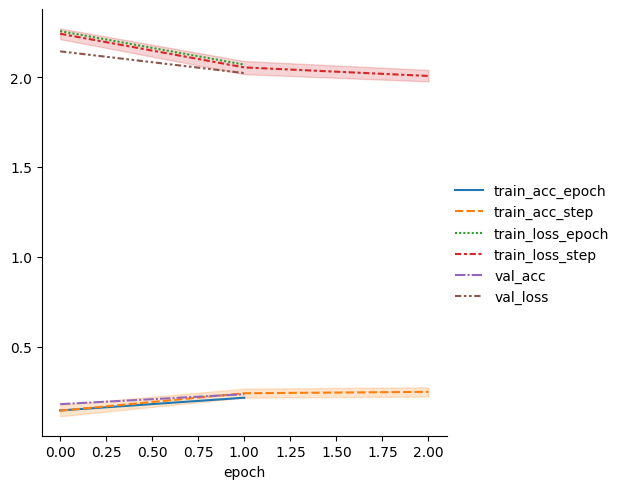

In [17]:
import pandas as pd
import seaborn as sn
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
sn.relplot(data=metrics, kind="line")

# Hyperparameters:
* Number of layers and units 
* Activation functions (ReLU, Sigmoid, Tanh, others)
* Optimizers (SGD, Adam, RMSprop) 
* Learning rate  - A
* Batch size - A
* Number of epochs  - A
* Weight initialization strategies (e.g., Xavier, He) 
* Dropout rate - A
* Batch Normalization (with vs without) 


Due to the need of a starting point, we started by using the parameters declared on the following link: https://www.chalisebibek.com.np/image-classification-with-pytorch-lightning-simple-ann. However, as we can see, the results are insatisfactory, which means that the hyperparameters need to be optimized. The current hyperparameters are not able to capture the complexity of the data. 

As stated before, due to the need of optimizing hyperparameters, we decided to increase the number of layers and continuing to funnel the number of neurons to try and prevent overfitting

In [18]:
'''trainer = pl.Trainer(max_epochs=10, callbacks=[early_stop_callback], logger=csv_logger)
trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)'''

'trainer = pl.Trainer(max_epochs=10, callbacks=[early_stop_callback], logger=csv_logger)\ntrainer.fit(model, train_loader, val_loader)\ntrainer.test(model, test_loader)'

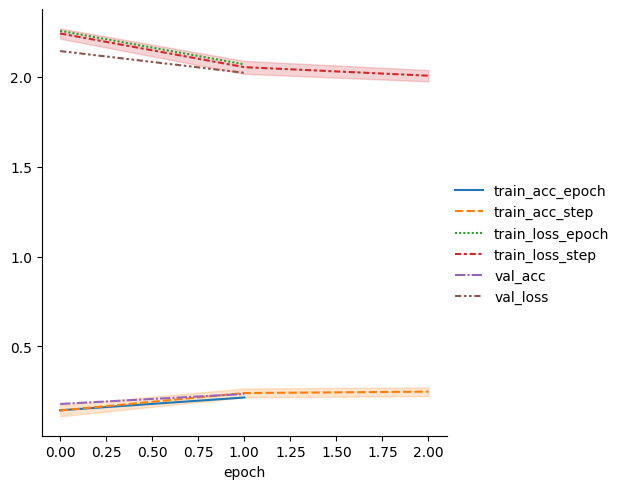

In [19]:
import pandas as pd
import seaborn as sn
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
sn.relplot(data=metrics, kind="line")

With the increase of the hidden layers, we can see that the accuracy and the loss both improved ever so slightly, without showing any signs of overfitting or underfitting. However, both metrics appear to be close to flatlining. So, in hopes of trying to discard the importance of the epochs, we tried to increase the number of epochs significantly and using early stopping with a min_delta of 0.005 to prevent overfitting. 


In [20]:
'''trainer = pl.Trainer(max_epochs=100, callbacks=[early_stop_callback], logger=csv_logger)
trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)'''

'trainer = pl.Trainer(max_epochs=100, callbacks=[early_stop_callback], logger=csv_logger)\ntrainer.fit(model, train_loader, val_loader)\ntrainer.test(model, test_loader)'

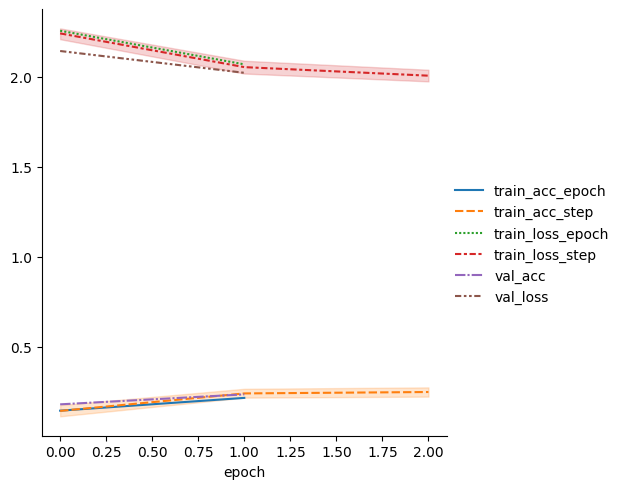

In [21]:
import pandas as pd
import seaborn as sn
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
sn.relplot(data=metrics, kind="line")

As we can see, there was a slight increase on performance on both the accuracy and the loss, but even though the number of epochs was set to 100, the training was stopped by the early stopping method, meaning it didn't improve enough to keep training. So, from now on, the number of epochs will always be 100 with early stopping of min_delta = 0.005

Since the early testing showed that increasing the number of hidden layers improved the performance, we decided to add one more hidden layer and test the result

In [22]:
trainer = pl.Trainer(max_epochs=100, callbacks=[early_stop_callback], logger=csv_logger)
trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params | Mode 
----------------------------------------
0 | fc1  | Linear | 393 K  | train
1 | fc2  | Linear | 8.3 K  | train
2 | fc3  | Linear | 2.1 K  | train
3 | fc4  | Linear | 528    | train
4 | fc5  | Linear | 170    | train
----------------------------------------
404 K     Trainable params
0         Non-trainable params
404 K     Total params
1.618     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\edmdu\Desktop\PG\FAP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


c:\Users\edmdu\Desktop\PG\FAP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 0: 100%|██████████| 704/704 [00:24<00:00, 28.33it/s, v_num=5]

Metric val_loss improved. New best score: 2.143


Epoch 1: 100%|██████████| 704/704 [00:29<00:00, 23.61it/s, v_num=5]

Metric val_loss improved by 0.121 >= min_delta = 0.005. New best score: 2.022


Epoch 2: 100%|██████████| 704/704 [00:29<00:00, 23.74it/s, v_num=5]

Metric val_loss improved by 0.100 >= min_delta = 0.005. New best score: 1.923


Epoch 3: 100%|██████████| 704/704 [00:30<00:00, 22.71it/s, v_num=5]

Metric val_loss improved by 0.072 >= min_delta = 0.005. New best score: 1.850


Epoch 4: 100%|██████████| 704/704 [00:30<00:00, 23.34it/s, v_num=5]

Metric val_loss improved by 0.065 >= min_delta = 0.005. New best score: 1.785


Epoch 5: 100%|██████████| 704/704 [00:31<00:00, 22.23it/s, v_num=5]

Metric val_loss improved by 0.035 >= min_delta = 0.005. New best score: 1.751


Epoch 6: 100%|██████████| 704/704 [00:28<00:00, 24.31it/s, v_num=5]

Metric val_loss improved by 0.051 >= min_delta = 0.005. New best score: 1.700


Epoch 7: 100%|██████████| 704/704 [00:27<00:00, 25.76it/s, v_num=5]

Metric val_loss improved by 0.035 >= min_delta = 0.005. New best score: 1.665


Epoch 8: 100%|██████████| 704/704 [00:26<00:00, 26.65it/s, v_num=5]

Metric val_loss improved by 0.025 >= min_delta = 0.005. New best score: 1.640


Epoch 9: 100%|██████████| 704/704 [00:25<00:00, 28.03it/s, v_num=5]

Metric val_loss improved by 0.036 >= min_delta = 0.005. New best score: 1.604


Epoch 10: 100%|██████████| 704/704 [00:27<00:00, 25.86it/s, v_num=5]

Metric val_loss improved by 0.018 >= min_delta = 0.005. New best score: 1.586


Epoch 11: 100%|██████████| 704/704 [00:25<00:00, 28.06it/s, v_num=5]

Metric val_loss improved by 0.019 >= min_delta = 0.005. New best score: 1.568


Epoch 12: 100%|██████████| 704/704 [00:26<00:00, 26.93it/s, v_num=5]

Metric val_loss improved by 0.006 >= min_delta = 0.005. New best score: 1.562


Epoch 14: 100%|██████████| 704/704 [00:25<00:00, 27.93it/s, v_num=5]

Metric val_loss improved by 0.040 >= min_delta = 0.005. New best score: 1.521


Epoch 15: 100%|██████████| 704/704 [00:26<00:00, 26.67it/s, v_num=5]

Metric val_loss improved by 0.011 >= min_delta = 0.005. New best score: 1.510


Epoch 17: 100%|██████████| 704/704 [00:28<00:00, 24.69it/s, v_num=5]

Metric val_loss improved by 0.016 >= min_delta = 0.005. New best score: 1.494


Epoch 19: 100%|██████████| 704/704 [00:21<00:00, 32.32it/s, v_num=5]

Metric val_loss improved by 0.009 >= min_delta = 0.005. New best score: 1.486


Epoch 20: 100%|██████████| 704/704 [00:21<00:00, 33.25it/s, v_num=5]

Metric val_loss improved by 0.008 >= min_delta = 0.005. New best score: 1.478


Epoch 21: 100%|██████████| 704/704 [00:20<00:00, 33.87it/s, v_num=5]

Metric val_loss improved by 0.012 >= min_delta = 0.005. New best score: 1.465


Epoch 22: 100%|██████████| 704/704 [00:20<00:00, 34.93it/s, v_num=5]

Metric val_loss improved by 0.005 >= min_delta = 0.005. New best score: 1.460


Epoch 25: 100%|██████████| 704/704 [00:21<00:00, 32.92it/s, v_num=5]

Metric val_loss improved by 0.033 >= min_delta = 0.005. New best score: 1.427


Epoch 26: 100%|██████████| 704/704 [00:20<00:00, 34.66it/s, v_num=5]

Metric val_loss improved by 0.006 >= min_delta = 0.005. New best score: 1.421


Epoch 30: 100%|██████████| 704/704 [00:19<00:00, 35.35it/s, v_num=5]

Metric val_loss improved by 0.016 >= min_delta = 0.005. New best score: 1.405


Epoch 31: 100%|██████████| 704/704 [00:19<00:00, 35.56it/s, v_num=5]

Metric val_loss improved by 0.011 >= min_delta = 0.005. New best score: 1.394


Epoch 36: 100%|██████████| 704/704 [00:19<00:00, 35.93it/s, v_num=5]

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.394. Signaling Trainer to stop.


Epoch 36: 100%|██████████| 704/704 [00:19<00:00, 35.88it/s, v_num=5]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\edmdu\Desktop\PG\FAP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:00<00:00, 215.44it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5169000029563904
        test_loss           1.3667247295379639
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.3667247295379639, 'test_acc': 0.5169000029563904}]

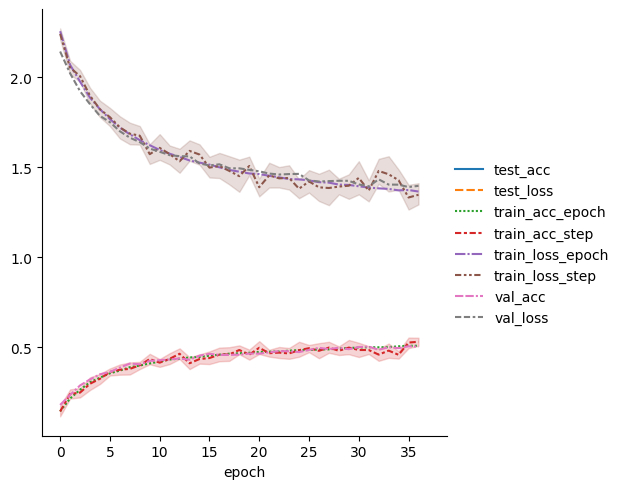

In [ ]:
'''import pandas as pd
import seaborn as sn
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
sn.relplot(data=metrics, kind="line")'''

As we can see, the increasing of the number of hidden layers (with funneling ) didn't provide any significant improve in accuracy and actually a worst value for loss. For that reason, we decided to go back to the last layout (without the last layer)


Next, we decided to test different activation functions, to see which one is better for the task at hands. We will start with the leaky relu

In [32]:
import pytorch_lightning as pl

model = LitANN(input_size=32*32*3, hidden_size=128, num_classes=10, learning_rate=0.001, activation_fn=F.leaky_relu)
csv_logger = CSVLogger("logs", name="ANN")
early_stop_callback = EarlyStopping(
    monitor='val_loss',   # or 'val_acc' if you log accuracy in validation_step
    min_delta=0.005,       # minimum change to count as improvement
    patience=5,           # how many validation epochs to wait for improvement
    verbose=True,
    mode='min'            # 'min' for loss, 'max' for accuracy
)

trainer = pl.Trainer(max_epochs=100, callbacks=[early_stop_callback], logger=csv_logger, )
trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params | Mode 
----------------------------------------
0 | fc1  | Linear | 393 K  | train
1 | fc2  | Linear | 8.3 K  | train
2 | fc3  | Linear | 2.1 K  | train
3 | fc4  | Linear | 330    | train
----------------------------------------
404 K     Trainable params
0         Non-trainable params
404 K     Total params
1.616     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\edmdu\Desktop\PG\FAP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


c:\Users\edmdu\Desktop\PG\FAP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 0: 100%|██████████| 704/704 [00:13<00:00, 50.49it/s, v_num=6] 

Metric val_loss improved. New best score: 1.974


Epoch 1: 100%|██████████| 704/704 [00:21<00:00, 32.36it/s, v_num=6]

Metric val_loss improved by 0.121 >= min_delta = 0.005. New best score: 1.852


Epoch 2: 100%|██████████| 704/704 [00:21<00:00, 32.93it/s, v_num=6]

Metric val_loss improved by 0.081 >= min_delta = 0.005. New best score: 1.771


Epoch 3: 100%|██████████| 704/704 [00:22<00:00, 31.65it/s, v_num=6]

Metric val_loss improved by 0.049 >= min_delta = 0.005. New best score: 1.722


Epoch 4: 100%|██████████| 704/704 [00:20<00:00, 34.04it/s, v_num=6]

Metric val_loss improved by 0.038 >= min_delta = 0.005. New best score: 1.684


Epoch 5: 100%|██████████| 704/704 [00:20<00:00, 35.10it/s, v_num=6]

Metric val_loss improved by 0.016 >= min_delta = 0.005. New best score: 1.668


Epoch 6: 100%|██████████| 704/704 [00:19<00:00, 35.43it/s, v_num=6]

Metric val_loss improved by 0.052 >= min_delta = 0.005. New best score: 1.616


Epoch 8: 100%|██████████| 704/704 [00:20<00:00, 35.14it/s, v_num=6]

Metric val_loss improved by 0.045 >= min_delta = 0.005. New best score: 1.570


Epoch 9: 100%|██████████| 704/704 [00:20<00:00, 34.60it/s, v_num=6]

Metric val_loss improved by 0.021 >= min_delta = 0.005. New best score: 1.549


Epoch 11: 100%|██████████| 704/704 [00:20<00:00, 34.92it/s, v_num=6]

Metric val_loss improved by 0.010 >= min_delta = 0.005. New best score: 1.539


Epoch 12: 100%|██████████| 704/704 [00:20<00:00, 34.72it/s, v_num=6]

Metric val_loss improved by 0.015 >= min_delta = 0.005. New best score: 1.524


Epoch 13: 100%|██████████| 704/704 [00:20<00:00, 34.96it/s, v_num=6]

Metric val_loss improved by 0.009 >= min_delta = 0.005. New best score: 1.515


Epoch 14: 100%|██████████| 704/704 [00:20<00:00, 35.06it/s, v_num=6]

Metric val_loss improved by 0.021 >= min_delta = 0.005. New best score: 1.494


Epoch 16: 100%|██████████| 704/704 [00:19<00:00, 35.22it/s, v_num=6]

Metric val_loss improved by 0.013 >= min_delta = 0.005. New best score: 1.481


Epoch 18: 100%|██████████| 704/704 [00:19<00:00, 35.55it/s, v_num=6]

Metric val_loss improved by 0.012 >= min_delta = 0.005. New best score: 1.470


Epoch 19: 100%|██████████| 704/704 [00:19<00:00, 35.57it/s, v_num=6]

Metric val_loss improved by 0.022 >= min_delta = 0.005. New best score: 1.447


Epoch 23: 100%|██████████| 704/704 [00:21<00:00, 33.01it/s, v_num=6]

Metric val_loss improved by 0.008 >= min_delta = 0.005. New best score: 1.439


Epoch 26: 100%|██████████| 704/704 [00:24<00:00, 28.27it/s, v_num=6]

Metric val_loss improved by 0.017 >= min_delta = 0.005. New best score: 1.422


Epoch 29: 100%|██████████| 704/704 [00:23<00:00, 29.47it/s, v_num=6]

Metric val_loss improved by 0.007 >= min_delta = 0.005. New best score: 1.415


Epoch 30: 100%|██████████| 704/704 [00:19<00:00, 36.90it/s, v_num=6]

Metric val_loss improved by 0.008 >= min_delta = 0.005. New best score: 1.406


Epoch 31:   9%|▊         | 61/704 [00:07<01:15,  8.46it/s, v_num=6] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000026E8B6891C0>
Traceback (most recent call last):
  File "c:\Users\edmdu\Desktop\PG\FAP\.venv\Lib\site-packages\torch\utils\data\dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "c:\Users\edmdu\Desktop\PG\FAP\.venv\Lib\site-packages\torch\utils\data\dataloader.py", line 1612, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
                                   ^^^^^^^^^^^^^^^^^^^^
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


Epoch 31: 100%|██████████| 704/704 [00:30<00:00, 23.35it/s, v_num=6]

Metric val_loss improved by 0.017 >= min_delta = 0.005. New best score: 1.389


Epoch 34: 100%|██████████| 704/704 [00:19<00:00, 36.95it/s, v_num=6]

Metric val_loss improved by 0.008 >= min_delta = 0.005. New best score: 1.381


Epoch 39: 100%|██████████| 704/704 [00:19<00:00, 36.61it/s, v_num=6]

Metric val_loss improved by 0.014 >= min_delta = 0.005. New best score: 1.367


Epoch 42: 100%|██████████| 704/704 [00:19<00:00, 36.80it/s, v_num=6]

Metric val_loss improved by 0.009 >= min_delta = 0.005. New best score: 1.358


Epoch 43: 100%|██████████| 704/704 [00:19<00:00, 35.85it/s, v_num=6]

Metric val_loss improved by 0.006 >= min_delta = 0.005. New best score: 1.352


Epoch 48: 100%|██████████| 704/704 [00:19<00:00, 36.75it/s, v_num=6]

Metric val_loss improved by 0.009 >= min_delta = 0.005. New best score: 1.343


Epoch 53: 100%|██████████| 704/704 [00:19<00:00, 36.99it/s, v_num=6]

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.343. Signaling Trainer to stop.


Epoch 53: 100%|██████████| 704/704 [00:19<00:00, 36.95it/s, v_num=6]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\edmdu\Desktop\PG\FAP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:00<00:00, 237.16it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.526199996471405
        test_loss           1.3398561477661133
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.3398561477661133, 'test_acc': 0.526199996471405}]

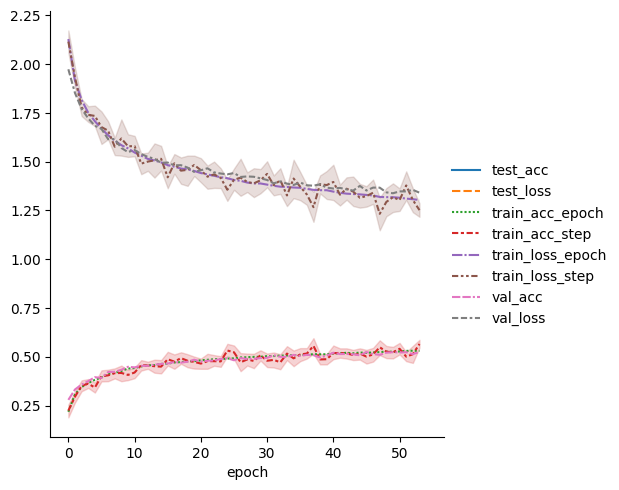

In [33]:
import pandas as pd
import seaborn as sn
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
sn.relplot(data=metrics, kind="line")

As we can see, changing the activation function to a leaky_relu, improved the accuracy, the loss and allowed the network to learn for a few more epochs. we will try with a different activation function.


In [34]:
model = LitANN(input_size=32*32*3, hidden_size=128, num_classes=10, learning_rate=0.001, activation_fn=F.elu)
csv_logger = CSVLogger("logs", name="ANN")
early_stop_callback = EarlyStopping(
    monitor='val_loss',   # or 'val_acc' if you log accuracy in validation_step
    min_delta=0.005,       # minimum change to count as improvement
    patience=5,           # how many validation epochs to wait for improvement
    verbose=True,
    mode='min'            # 'min' for loss, 'max' for accuracy
)

trainer = pl.Trainer(max_epochs=100, callbacks=[early_stop_callback], logger=csv_logger, )
trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params | Mode 
----------------------------------------
0 | fc1  | Linear | 393 K  | train
1 | fc2  | Linear | 8.3 K  | train
2 | fc3  | Linear | 2.1 K  | train
3 | fc4  | Linear | 330    | train
----------------------------------------
404 K     Trainable params
0         Non-trainable params
404 K     Total params
1.616     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\edmdu\Desktop\PG\FAP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


c:\Users\edmdu\Desktop\PG\FAP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 0: 100%|██████████| 704/704 [00:13<00:00, 52.60it/s, v_num=7] 

Metric val_loss improved. New best score: 1.922


Epoch 1: 100%|██████████| 704/704 [00:22<00:00, 31.84it/s, v_num=7]

Metric val_loss improved by 0.095 >= min_delta = 0.005. New best score: 1.827


Epoch 2: 100%|██████████| 704/704 [00:24<00:00, 28.62it/s, v_num=7]

Metric val_loss improved by 0.067 >= min_delta = 0.005. New best score: 1.760


Epoch 3: 100%|██████████| 704/704 [00:24<00:00, 29.01it/s, v_num=7]

Metric val_loss improved by 0.044 >= min_delta = 0.005. New best score: 1.715


Epoch 4: 100%|██████████| 704/704 [00:22<00:00, 31.91it/s, v_num=7]

Metric val_loss improved by 0.033 >= min_delta = 0.005. New best score: 1.682


Epoch 5: 100%|██████████| 704/704 [00:21<00:00, 33.30it/s, v_num=7]

Metric val_loss improved by 0.032 >= min_delta = 0.005. New best score: 1.650


Epoch 6: 100%|██████████| 704/704 [00:21<00:00, 33.39it/s, v_num=7]

Metric val_loss improved by 0.037 >= min_delta = 0.005. New best score: 1.613


Epoch 7: 100%|██████████| 704/704 [00:21<00:00, 32.34it/s, v_num=7]

Metric val_loss improved by 0.014 >= min_delta = 0.005. New best score: 1.599


Epoch 8: 100%|██████████| 704/704 [00:21<00:00, 32.31it/s, v_num=7]

Metric val_loss improved by 0.010 >= min_delta = 0.005. New best score: 1.589


Epoch 9: 100%|██████████| 704/704 [00:21<00:00, 33.35it/s, v_num=7]

Metric val_loss improved by 0.013 >= min_delta = 0.005. New best score: 1.576


Epoch 11: 100%|██████████| 704/704 [00:21<00:00, 32.93it/s, v_num=7]

Metric val_loss improved by 0.033 >= min_delta = 0.005. New best score: 1.543


Epoch 12: 100%|██████████| 704/704 [00:21<00:00, 32.51it/s, v_num=7]

Metric val_loss improved by 0.021 >= min_delta = 0.005. New best score: 1.522


Epoch 13: 100%|██████████| 704/704 [00:19<00:00, 36.28it/s, v_num=7]

Metric val_loss improved by 0.010 >= min_delta = 0.005. New best score: 1.512


Epoch 14: 100%|██████████| 704/704 [00:19<00:00, 35.81it/s, v_num=7]

Metric val_loss improved by 0.013 >= min_delta = 0.005. New best score: 1.499


Epoch 15: 100%|██████████| 704/704 [00:19<00:00, 35.63it/s, v_num=7]

Metric val_loss improved by 0.007 >= min_delta = 0.005. New best score: 1.492


Epoch 17: 100%|██████████| 704/704 [00:20<00:00, 34.36it/s, v_num=7]

Metric val_loss improved by 0.022 >= min_delta = 0.005. New best score: 1.470


Epoch 18: 100%|██████████| 704/704 [00:20<00:00, 34.26it/s, v_num=7]

Metric val_loss improved by 0.007 >= min_delta = 0.005. New best score: 1.463


Epoch 19: 100%|██████████| 704/704 [00:21<00:00, 33.51it/s, v_num=7]

Metric val_loss improved by 0.016 >= min_delta = 0.005. New best score: 1.447


Epoch 22: 100%|██████████| 704/704 [00:21<00:00, 32.06it/s, v_num=7]

Metric val_loss improved by 0.006 >= min_delta = 0.005. New best score: 1.441


Epoch 23: 100%|██████████| 704/704 [00:21<00:00, 32.47it/s, v_num=7]

Metric val_loss improved by 0.007 >= min_delta = 0.005. New best score: 1.434


Epoch 24: 100%|██████████| 704/704 [00:21<00:00, 32.65it/s, v_num=7]

Metric val_loss improved by 0.011 >= min_delta = 0.005. New best score: 1.422


Epoch 25: 100%|██████████| 704/704 [00:21<00:00, 32.88it/s, v_num=7]

Metric val_loss improved by 0.006 >= min_delta = 0.005. New best score: 1.417


Epoch 27: 100%|██████████| 704/704 [00:21<00:00, 32.81it/s, v_num=7]

Metric val_loss improved by 0.006 >= min_delta = 0.005. New best score: 1.410


Epoch 28: 100%|██████████| 704/704 [00:21<00:00, 33.26it/s, v_num=7]

Metric val_loss improved by 0.005 >= min_delta = 0.005. New best score: 1.405


Epoch 29: 100%|██████████| 704/704 [00:21<00:00, 33.23it/s, v_num=7]

Metric val_loss improved by 0.006 >= min_delta = 0.005. New best score: 1.399


Epoch 30: 100%|██████████| 704/704 [00:21<00:00, 32.54it/s, v_num=7]

Metric val_loss improved by 0.005 >= min_delta = 0.005. New best score: 1.394


Epoch 33: 100%|██████████| 704/704 [00:21<00:00, 33.24it/s, v_num=7]

Metric val_loss improved by 0.016 >= min_delta = 0.005. New best score: 1.377


Epoch 37: 100%|██████████| 704/704 [00:20<00:00, 34.08it/s, v_num=7]

Metric val_loss improved by 0.007 >= min_delta = 0.005. New best score: 1.370


Epoch 41: 100%|██████████| 704/704 [00:20<00:00, 34.70it/s, v_num=7]

Metric val_loss improved by 0.005 >= min_delta = 0.005. New best score: 1.365


Epoch 44: 100%|██████████| 704/704 [00:21<00:00, 32.03it/s, v_num=7]

Metric val_loss improved by 0.021 >= min_delta = 0.005. New best score: 1.344


Epoch 49: 100%|██████████| 704/704 [00:21<00:00, 32.49it/s, v_num=7]

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.344. Signaling Trainer to stop.


Epoch 49: 100%|██████████| 704/704 [00:21<00:00, 32.46it/s, v_num=7]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\edmdu\Desktop\PG\FAP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:00<00:00, 210.56it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5232999920845032
        test_loss           1.3328932523727417
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.3328932523727417, 'test_acc': 0.5232999920845032}]

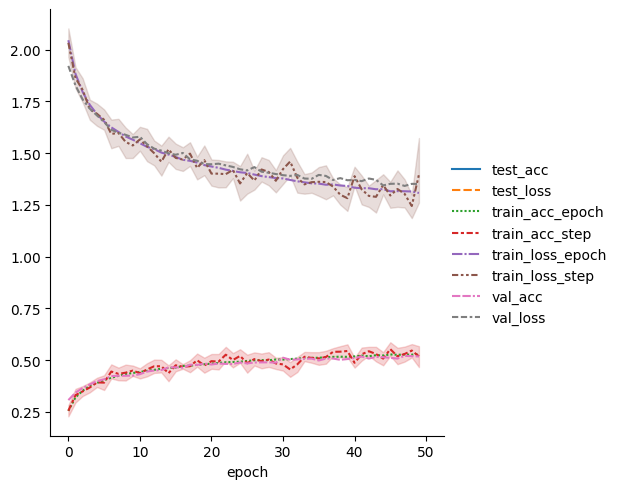

In [35]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
sn.relplot(data=metrics, kind="line")

so far, this hasn't been better than the leaky relu, we will try with a different one

In [36]:
model = LitANN(input_size=32*32*3, hidden_size=128, num_classes=10, learning_rate=0.001, activation_fn=F.tanh)
csv_logger = CSVLogger("logs", name="ANN")
early_stop_callback = EarlyStopping(
    monitor='val_loss',   # or 'val_acc' if you log accuracy in validation_step
    min_delta=0.005,       # minimum change to count as improvement
    patience=5,           # how many validation epochs to wait for improvement
    verbose=True,
    mode='min'            # 'min' for loss, 'max' for accuracy
)

trainer = pl.Trainer(max_epochs=100, callbacks=[early_stop_callback], logger=csv_logger, )
trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params | Mode 
----------------------------------------
0 | fc1  | Linear | 393 K  | train
1 | fc2  | Linear | 8.3 K  | train
2 | fc3  | Linear | 2.1 K  | train
3 | fc4  | Linear | 330    | train
----------------------------------------
404 K     Trainable params
0         Non-trainable params
404 K     Total params
1.616     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\edmdu\Desktop\PG\FAP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


c:\Users\edmdu\Desktop\PG\FAP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 0: 100%|██████████| 704/704 [00:13<00:00, 53.42it/s, v_num=8] 

Metric val_loss improved. New best score: 1.985


Epoch 1: 100%|██████████| 704/704 [00:21<00:00, 33.43it/s, v_num=8]

Metric val_loss improved by 0.094 >= min_delta = 0.005. New best score: 1.892


Epoch 2: 100%|██████████| 704/704 [00:19<00:00, 35.51it/s, v_num=8]

Metric val_loss improved by 0.062 >= min_delta = 0.005. New best score: 1.830


Epoch 3: 100%|██████████| 704/704 [00:19<00:00, 36.01it/s, v_num=8]

Metric val_loss improved by 0.064 >= min_delta = 0.005. New best score: 1.766


Epoch 4: 100%|██████████| 704/704 [00:19<00:00, 36.01it/s, v_num=8]

Metric val_loss improved by 0.038 >= min_delta = 0.005. New best score: 1.728


Epoch 5: 100%|██████████| 704/704 [00:19<00:00, 36.34it/s, v_num=8]

Metric val_loss improved by 0.027 >= min_delta = 0.005. New best score: 1.701


Epoch 6: 100%|██████████| 704/704 [00:19<00:00, 36.44it/s, v_num=8]

Metric val_loss improved by 0.042 >= min_delta = 0.005. New best score: 1.659


Epoch 7: 100%|██████████| 704/704 [00:19<00:00, 35.85it/s, v_num=8]

Metric val_loss improved by 0.011 >= min_delta = 0.005. New best score: 1.648


Epoch 8: 100%|██████████| 704/704 [00:19<00:00, 35.76it/s, v_num=8]

Metric val_loss improved by 0.011 >= min_delta = 0.005. New best score: 1.637


Epoch 9: 100%|██████████| 704/704 [00:19<00:00, 36.06it/s, v_num=8]

Metric val_loss improved by 0.030 >= min_delta = 0.005. New best score: 1.608


Epoch 11: 100%|██████████| 704/704 [00:19<00:00, 35.98it/s, v_num=8]

Metric val_loss improved by 0.015 >= min_delta = 0.005. New best score: 1.592


Epoch 12: 100%|██████████| 704/704 [00:19<00:00, 36.30it/s, v_num=8]

Metric val_loss improved by 0.010 >= min_delta = 0.005. New best score: 1.582


Epoch 13: 100%|██████████| 704/704 [00:19<00:00, 36.03it/s, v_num=8]

Metric val_loss improved by 0.021 >= min_delta = 0.005. New best score: 1.561


Epoch 14: 100%|██████████| 704/704 [00:19<00:00, 35.77it/s, v_num=8]

Metric val_loss improved by 0.020 >= min_delta = 0.005. New best score: 1.541


Epoch 17: 100%|██████████| 704/704 [00:19<00:00, 36.41it/s, v_num=8]

Metric val_loss improved by 0.012 >= min_delta = 0.005. New best score: 1.529


Epoch 19: 100%|██████████| 704/704 [00:19<00:00, 36.19it/s, v_num=8]

Metric val_loss improved by 0.010 >= min_delta = 0.005. New best score: 1.519


Epoch 22: 100%|██████████| 704/704 [00:20<00:00, 34.57it/s, v_num=8]

Metric val_loss improved by 0.022 >= min_delta = 0.005. New best score: 1.497


Epoch 26: 100%|██████████| 704/704 [00:20<00:00, 35.13it/s, v_num=8]

Metric val_loss improved by 0.010 >= min_delta = 0.005. New best score: 1.486


Epoch 27: 100%|██████████| 704/704 [00:20<00:00, 33.75it/s, v_num=8]

Metric val_loss improved by 0.007 >= min_delta = 0.005. New best score: 1.479


Epoch 31: 100%|██████████| 704/704 [00:19<00:00, 35.31it/s, v_num=8]

Metric val_loss improved by 0.026 >= min_delta = 0.005. New best score: 1.452


Epoch 36: 100%|██████████| 704/704 [00:19<00:00, 35.45it/s, v_num=8]

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.452. Signaling Trainer to stop.


Epoch 36: 100%|██████████| 704/704 [00:19<00:00, 35.42it/s, v_num=8]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\edmdu\Desktop\PG\FAP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:00<00:00, 218.15it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3684999942779541
        test_loss           1.9061437845230103
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.9061437845230103, 'test_acc': 0.3684999942779541}]

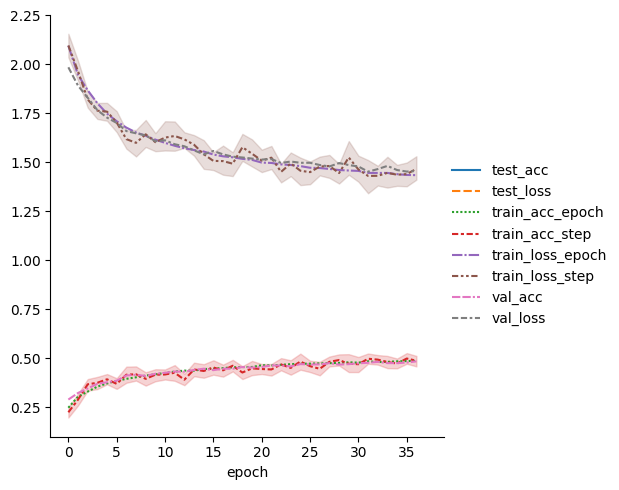

In [37]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
sn.relplot(data=metrics, kind="line")

In [ ]:
model = LitANN(input_size=32*32*3, hidden_size=128, num_classes=10, learning_rate=0.001, activation_fn=F.sigmoid)
csv_logger = CSVLogger("logs", name="ANN")
early_stop_callback = EarlyStopping(
    monitor='val_loss',   # or 'val_acc' if you log accuracy in validation_step
    min_delta=0.005,       # minimum change to count as improvement
    patience=5,           # how many validation epochs to wait for improvement
    verbose=True,
    mode='min'            # 'min' for loss, 'max' for accuracy
)

trainer = pl.Trainer(max_epochs=100, callbacks=[early_stop_callback], logger=csv_logger, )
trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\edmdu\Desktop\PG\FAP\.venv\Lib\site-packages\torch\__init__.py:1551: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:85.)
  return _C._get_float32_m

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\edmdu\Desktop\PG\FAP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


c:\Users\edmdu\Desktop\PG\FAP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 0: 100%|██████████| 704/704 [00:31<00:00, 22.67it/s, v_num=10]

Metric val_loss improved. New best score: 2.303


Epoch 5:   0%|          | 0/704 [00:00<?, ?it/s, v_num=10]          

In [ ]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
sn.relplot(data=metrics, kind="line")